In [52]:
import matplotlib.pyplot as plt
import numpy as np
# from collections import defaultdict
from main import parse_config, instantiate_agents, instantiate_auction, simulation_run
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm
# from Bidder import *

In [53]:
# config_file = '../config-mine/FP_Epsilon-average-out-results-test.json'
# config_file = '../config-mine/FP_EpsilonGreedy.json'
# config_file = '../config-mine/SP_UCB1.json'
# config_file = '../config-mine/SP_Exp3-Truthful.json'
# config_file = '../config-mine/FP_Exp3-Truthful.json'
# config_file = '../config-mine/SP_Exp3.json'
# config_file = '../config-mine/SP_EpsilonGreedy-Exp3-UCB1.json'
# config_file = '../config-mine/FP_UCB1-BIGPR.json'
# config_file = '../config-mine/FP_UCB1-Exp3.json'
# config_file = '../config-mine/FP_Exp3.json'
# config_file = '../config-mine/SP_Expert.json'

# config_file = '../config-mine/SP_GPUCB-Exp3.json'
# config_file = '../config-mine/SP_IGPR-Exp3.json'
# config_file = '../config-mine/SP_warmGPR-Exp3.json'
# config_file = '../config-mine/SP_warmGPR-UCB1.json'
# config_file = '../config-mine/SP_warmGPR-IGPR.json'

# config_file = '../config-mine/SP_BIGPR.json'
# config_file = '../config-mine/SP_BIGPR-warmGPR.json'
# config_file = '../config-mine/SP_BIGPR-Exp3.json'
# config_file = '../config-mine/SP_BIGPR-Expert.json'
# config_file = '../config-mine/SP_BIGPR-Exp3-Expert.json'

# config_file = '../config-mine/SP_SAC-Exp3.json'
# config_file = '../config-mine/SP_SB3-discr-vs-cont.json'

# config_file = '../config-mine/SP_GPUCB-ctxt.json'
# config_file = '../config-mine/SP_Expert-Exp3.json'
# config_file = '../config-mine/SP_EpsilonGreedy-Exp3-ExpertKMeans.json'

# config_file = '../config-mine/Novelty/SP_NoveltyNN-Exp3.json'
# config_file = '../config-mine/Novelty/FP_NoveltyDirectSGD-Exp3.json'
# config_file = '../config-mine/Novelty/FP_NoveltyDirectBIGPR-Exp3.json'
# config_file = '../config-mine/Novelty/FP_NoveltySGD-NoveltyBIGPR-Exp3-Expert.json'

# config_file = '../config-mine/SP_TruthfulBandit_gather_data.json'

#static bidders config
# config_file = '../config-mine/Static/FP_static_bidder.json'
# config_file = '../config-mine/Static/FP_static-Expert.json'
# config_file = '../config-mine/Static/FP_static-NoveltySGD.json'

# config_file = '../config-mine/Static/FP_static2-clairevoyant.json'
config_file = '../config-mine/Static/FP_static2-Exp3.json'
# config_file = '../config-mine/Static/FP_static2-Exp3IX.json'
# config_file = '../config-mine/Static/FP_static2-Expert.json'

graph_title = config_file

In [54]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values,\
num_runs, max_slots, embedding_size, embedding_var,\
obs_embedding_size = parse_config(config_file)

num_iter = config['num_iter']

print('--- Auction ---')
print(config['allocation'])
print()

print('--- My Agents ---')
my_agents_names = []
iter=0
for agent in config['agents']:
    for copies in range(agent['num_copies']):
        iter+=1
        # my_agents_names.append(f'{i}.{agent["bidder"]["type"]} ({agent["name"]})')
        my_agents_names.append(f'{iter}. {agent["name"]}')
        # print(f'{i}) {agent["bidder"]["type"]}')
print(my_agents_names)

print()
print('--- Runs Number ---')
print(f"making {config['num_runs']} runs\n  for each, {config['num_iter']} iterations\n    for each, {config['rounds_per_iter']} episodes")
print(f"\t -> total: {config['num_runs']*config['num_iter']*config['rounds_per_iter']}")

--- Auction ---
FirstPrice

--- My Agents ---
['1. Static Bidder 1', '2. Static Bidder 2', '3. Static Bidder 3', '4. Exp3 Bidder']

--- Runs Number ---
making 5 runs
  for each, 10000 iterations
    for each, 10 episodes
	 -> total: 500000


#### taking first agent product and giving it to everybody

##### while removing all other objects (oevrwriting the value in config)
##### or giving all agents just one product

In [55]:
ALL_AGENT_SAME_ITEM = True
REDUCE_TO_ONE_ITEM = False
agents_names = list(agents2items.keys())
assert agents_names[0] == list(agents2item_values.keys())[0] 

if ALL_AGENT_SAME_ITEM:     #assigns agent 1 items to all agents
    agents2items = { agent_name: agents2items[agents_names[-1]] for agent_name in agents_names }
    agents2item_values = { agent_name: agents2item_values[agents_names[-1]] for agent_name in agents_names }

if REDUCE_TO_ONE_ITEM:      # only keeps first item for each agent
    agents2items = { agent_name: agents2items[agent_name][:1] for agent_name in agents_names }
    agents2item_values = { agent_name: agents2item_values[agent_name][:1] for agent_name in agents_names }

# obj_embed, obj_value
for agent_name in agents_names:
    print(f'{agent_name}')
    for i in range(len(agents2items[agent_name])):
        print(f"{agents2items[agent_name][i]}  ->   {agents2item_values[agent_name][i]:.4f}")
    print()

Static Bidder 1 1
[ 2.25 -1.92  1.10 -0.33 -0.88 -3.96]  ->   1.0811

Static Bidder 2 2
[ 2.25 -1.92  1.10 -0.33 -0.88 -3.96]  ->   1.0811

Static Bidder 3 3
[ 2.25 -1.92  1.10 -0.33 -0.88 -3.96]  ->   1.0811

Exp3 Bidder 4
[ 2.25 -1.92  1.10 -0.33 -0.88 -3.96]  ->   1.0811



### run_repeated_auctions

In [56]:
def run_repeated_auctions(num_run, num_runs, results=None, debug=False):
    # Placeholders for output
    auction_revenue = []
    social_welfare = []
    advertisers_surplus = []
    
    # Instantiate Agent and Auction objects
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
    
    agents_overall_surplus = [[] for _ in range(len(agents))]

    agents_instant_surplus = [[] for _ in range(len(agents))]

    agents_regret_history = [[] for _ in range(len(agents))]
    agents_actionsrewards_history = [[] for _ in range(len(agents))]

    clairevoyant_regret = []
    average_actions = []

    ### SECONDARY OUTPUTS ###
    agents_last_avg_utilities = [[] for _ in range(len(agents))]

    agents_bids_log = []

    # Instantiate Auction object
    auction, num_iter, rounds_per_iter, output_dir =\
        instantiate_auction(rng,
                            config,
                            agents2items,
                            agents2item_values,
                            agents,
                            max_slots,
                            embedding_size,
                            embedding_var,
                            obs_embedding_size)
    
    # give bidder info about the auction type (2nd price, 1st price, etc.)
    # to calculate REGRET IN HINDISGHT
    from BidderBandits import BaseBidder, StaticBidder2
    for iter, agent in enumerate(auction.agents):
        if isinstance(agent.bidder, BaseBidder):
            agent.bidder.auction_type = config['allocation']
            agent.bidder.agent_id = iter
            agent.bidder.num_iterations = num_iter
            # agent.bidder.total_num_auctions = num_iter * rounds_per_iter
            # agent.bidder.item_values = agent.item_values
            if num_run == 0: 
                if not agent.bidder.isContinuous:
                    print('\t', agent.name, ': ', agent.bidder.BIDS)
                else:
                    print('\t', agent.name, ': ', agent.bidder.textContinuous)
            if not isinstance(agent.bidder, StaticBidder2):
                import joblib
                from utils import get_project_root
                agent.bidder.clairevoyant = joblib.load(get_project_root() / "src" / "models" / "clairevoyant" / "20230912-1147.joblib")

    if debug:
        for agent in auction.agents:
            print(agent.name, ': ', agent.bidder.auction_type, end=' | ')

    # Run repeated auctions
    # This logic is encoded in the `simulation_run()` method in main.py
    # print(num_run, ') ', end='')
    for iter in tqdm(range(num_iter), desc=f'{num_run+1}/{num_runs}', leave=True):
        if debug:
            print(f'Iteration {iter+1} of {num_iter}')

        # Simulate impression opportunities
        opportunities_results = []
        for _ in range(rounds_per_iter):
            opportunities_results.append( auction.simulate_opportunity() )

        participating_agents_ids = np.array(np.array(opportunities_results)[:,0,:], dtype=np.int32)
        iter_bids = np.array(np.array(opportunities_results)[:,1,:], dtype=np.float32)
        
        participating_agents_masks = [np.isin(participating_agents_ids, agent).any(axis=1) for agent in range(len(agents))]

        sorted_bids_iter = np.sort(iter_bids, axis=1)
        maximum_bids_iter = sorted_bids_iter[:,-1]
        second_maximum_bids_iter = sorted_bids_iter[:,-2]

        # Log 'Gross utility' or welfare
        social_welfare.append(sum([agent.gross_utility for agent in auction.agents]))

        # Log 'Net utility' or surplus
        advertisers_surplus.append(sum([agent.net_utility for agent in auction.agents]))
        for agent_id, agent in enumerate(auction.agents):
            #surplus
            # DEPRECATED WAY TO TAKE SURPLUS
            # agents_instant_surplus[agent_id].append(agent.net_utility)
            # agents_overall_surplus[agent_id].append(np.array(agents_instant_surplus[agent_id], dtype=object).sum())
            
            # winning bids
            agent.bidder.winning_bids = maximum_bids_iter[participating_agents_masks[agent_id]]
            agent.bidder.second_winning_bids = second_maximum_bids_iter[participating_agents_masks[agent_id]]

        # logging bids
        agents_bids_log.extend( [ [agent.logs[j].bid for agent in agents]  for j in range(len(agent.logs)) ] )

        # Update agents
        # Clear running metrics
        for agent_id, agent in enumerate(auction.agents):
            if(len(agent.logs)>0):
                if debug:
                    print(f'\t agent update: {my_agents_names[agent_id]}')
                agent.update(iteration=iter)
                # if i==num_iter-1:
                #     agents_last_avg_utilities[agent_id].append(agent.bidder.expected_utilities)
                agent.clear_utility()
                agent.clear_logs()

        # Log revenue
        auction_revenue.append(auction.revenue)
        auction.clear_revenue()
    
    # regret retrievement
    for agent_id, agent in enumerate(auction.agents):
        agents_instant_surplus[agent_id] = agent.bidder.surpluses
        agents_overall_surplus[agent_id] = np.cumsum(agents_instant_surplus[agent_id])
        agents_regret_history[agent_id] = agent.bidder.regret
        agents_actionsrewards_history[agent_id] = agent.bidder.actions_rewards
        if not isinstance(agent.bidder, StaticBidder2):
            clairevoyant_regret.append(agent.bidder.clairevoyant_regret)
        average_actions.append(agent.bidder.average_action)
        pass

    # Rescale metrics per auction round
    auction_revenue = np.array(auction_revenue, dtype=object) / rounds_per_iter
    social_welfare = np.array(social_welfare, dtype=object) / rounds_per_iter
    advertisers_surplus = np.array(advertisers_surplus, dtype=object) / rounds_per_iter

    ### SECONDARY OUTPUTS ###
    # secondary_outputs.append((agents_last_avg_utilities, [a.bidder.BIDS for a in auction.agents]))

    if results is not None:
        results[num_run] = (
            auction_revenue, social_welfare, advertisers_surplus, 
            agents_overall_surplus, agents_instant_surplus, 
            agents_regret_history, agents_actionsrewards_history,
            clairevoyant_regret, average_actions
        )
                    
        
    return auction_revenue, social_welfare, advertisers_surplus,\
            agents_overall_surplus, agents_instant_surplus,\
            agents_regret_history, agents_actionsrewards_history,\
            clairevoyant_regret, average_actions

In [57]:
# INDEXES of the return
idx_auction_rev = 0
idx_social_welfare = 1
idx_advertisers_surplus = 2
idx_cumulative_surpluses = 3
idx_instant_surpluses = 4
idx_regrets = 5
idx_actions_rewards = 6
idx_cv_regret = 7
idx_average_actions = 8

# RUN

In [58]:
secondary_outputs = []
debug=False

runs_results = [None for _ in range(num_runs)]

res = [run_repeated_auctions(i, num_runs, runs_results, debug) for i in range(num_runs)]
# print(runs_results.shape)

	 Static Bidder 1 1 :  [ 0.01  0.03  0.10  0.20  0.30  0.50  0.70  0.80  1.00  1.10  1.40]
	 Static Bidder 2 2 :  [ 0.01  0.03  0.10  0.20  0.30  0.50  0.70  0.80  1.00  1.10  1.40]
	 Static Bidder 3 3 :  [ 0.01  0.03  0.10  0.20  0.30  0.50  0.70  0.80  1.00  1.10  1.40]
	 Exp3 Bidder 4 :  [ 0.01  0.03  0.10  0.20  0.30  0.50  0.70  0.80  1.00  1.10  1.40]


1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
'''
# from threading import Thread

# secondary_outputs = []
# debug=False

# runs_results = [None for _ in range(num_runs)]
# threads = [Thread(target=run_repeated_auctions, args=(i, num_runs, runs_results, debug)) for i in range(num_runs)]

# n_prox = 1 #num_runs

# i=0
# j=0
# while i < num_runs:
#     # print(i,' &&& ',j)
#     for j in range(n_prox):
#         if i+j >= len(threads):
#             break
#         threads[i+j].start()
        
#     for j in range(n_prox):
#         if i+j >= len(threads):
#             break
#         threads[i+j].join()
    
#     i+=n_prox

#     # runs_results.append(run_repeated_auctions(num_run=i, num_runs=num_runs, debug=debug))
# # [run_repeated_auctions(num_run=i+1, num_runs=num_runs, debug=debug) for i in range(num_runs)]
# # print(num_participants_2_metrics)
'''

"\n# from threading import Thread\n\n# secondary_outputs = []\n# debug=False\n\n# runs_results = [None for _ in range(num_runs)]\n# threads = [Thread(target=run_repeated_auctions, args=(i, num_runs, runs_results, debug)) for i in range(num_runs)]\n\n# n_prox = 1 #num_runs\n\n# i=0\n# j=0\n# while i < num_runs:\n#     # print(i,' &&& ',j)\n#     for j in range(n_prox):\n#         if i+j >= len(threads):\n#             break\n#         threads[i+j].start()\n        \n#     for j in range(n_prox):\n#         if i+j >= len(threads):\n#             break\n#         threads[i+j].join()\n    \n#     i+=n_prox\n\n#     # runs_results.append(run_repeated_auctions(num_run=i, num_runs=num_runs, debug=debug))\n# # [run_repeated_auctions(num_run=i+1, num_runs=num_runs, debug=debug) for i in range(num_runs)]\n# # print(num_participants_2_metrics)\n"

### print surpluses - for each run

In [ ]:
print(my_agents_names)
total_surpluses = [[] for _ in range(len(my_agents_names))]

np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

for h, run in enumerate(runs_results):
    a_s = run[idx_cumulative_surpluses]
    i_s = run[idx_instant_surpluses]
    cumulatives = [np.float32(s[-1]).round(2) for s in  a_s]
    surpluses = np.array([np.array(surp).sum().round(2) for surp in i_s], dtype=object)
    for iter in range(len(i_s)):
        total_surpluses[iter].append(surpluses[iter])

    print_surpluses = ' '.join('{:7.2f}'.format(x) for x in surpluses)
    print_cumulatives = ' '.join('{:7.2f}'.format(x) for x in cumulatives)
    print(f'Run {h+1:=2}/{num_runs} -> surpluses: {print_surpluses}     |     last cumulative {print_cumulatives}')

# overall
total_surpluses = np.array( [np.array(x).mean() for x in total_surpluses] )
print_overall = ' '.join('{:7.2f}'.format(np.array(x).mean()) for x in total_surpluses)
print('\n     PER-RUN AVERAGE: ', '[' + (print_overall) + ']')

['1. Static Bidder 1', '2. Static Bidder 2', '3. Static Bidder 3', '4. Exp3 Bidder']
Run  1/5 -> surpluses: -9000.07 -5799.37 -10016.46 1655.37     |     last cumulative -9000.14 -5799.53 -10016.57 1655.39
Run  2/5 -> surpluses: -8837.72 -5894.33 -9945.68 1540.63     |     last cumulative -8837.75 -5894.53 -9945.78 1540.69
Run  3/5 -> surpluses: -9069.68 -5872.32 -9884.08  875.18     |     last cumulative -9069.76 -5872.57 -9884.13  875.19
Run  4/5 -> surpluses: -9057.20 -5839.49 -10010.12 1705.16     |     last cumulative -9057.26 -5839.68 -10010.18 1705.18
Run  5/5 -> surpluses: -8916.40 -5948.26 -9648.24 -695.97     |     last cumulative -8916.34 -5948.38 -9648.20 -696.02

     PER-RUN AVERAGE:  [-8976.21 -5870.75 -9900.92 1016.07]


### print regrets

In [ ]:
print(my_agents_names)

regrets = np.array([run[idx_regrets] for run in runs_results])

# print(regrets.shape)

# print(len(regrets[0][0]), len(regrets[0][1]), len(regrets[0][2]), len(regrets[0][3]))
# print(len(regrets[0][3][0]))

print(regrets[:,0,:].shape)

for h, run in enumerate(runs_results):
    reg = run[idx_regrets]
    # print(reg[0])
    # print(reg[1])
    reg = np.array([np.array(r).sum() for r in reg])
    print_regrets = ' '.join('\t{:10.2f}'.format(x) for x in reg)
    print(f'Run {h+1:=2}/{num_runs} -> regrets: {print_regrets}')

['1. Static Bidder 1', '2. Static Bidder 2', '3. Static Bidder 3', '4. Exp3 Bidder']
(5, 100000)
Run  1/5 -> regrets: 	  31296.99 	  28475.41 	  32676.93 	  18659.67
Run  2/5 -> regrets: 	  31083.23 	  28515.48 	  32573.18 	  18880.67
Run  3/5 -> regrets: 	  30863.58 	  27999.49 	  32010.61 	  19448.92
Run  4/5 -> regrets: 	  31237.84 	  28348.44 	  32522.04 	  18528.03
Run  5/5 -> regrets: 	  29567.78 	  26925.05 	  30650.43 	  21026.11


### print average actions, rewards

In [ ]:
# NB DOESNT WORK WHEN num_participants < num_agents, only when equal

print(my_agents_names)
num_agents = len(my_agents_names)
num_participants_per_round = config["num_participants_per_round"]

actions_rewards = [[] for _ in range(len(my_agents_names))]
regrets = [[] for _ in range(len(my_agents_names))]

for h, run in enumerate(runs_results):
    # r, w, s, a_s, i_s = run
    a_r = run[idx_actions_rewards]
    reg = run[idx_regrets]
    # regrets = run[idx_regrets]
    for iter in range(len(a_r)):
        actions_rewards[iter].extend(a_r[iter])
        regrets[iter].extend(reg[iter])

ar = np.array(actions_rewards, dtype=object)
regrets = np.array(regrets, dtype=object)

if num_participants_per_round == num_agents:
    avg_ar = np.mean(np.reshape(ar, (num_agents, -1, 2)), axis=1) # 2 since actions_rewards is a list of [(action, reward), ...]
    avg_ar = avg_ar.astype(np.float32).round(2)
    avg_ar = avg_ar.transpose(1,0)
    print("avg actions: ", end="\t")
    print(avg_ar[0])
    print("avg rewards: ", end="\t")
    print(avg_ar[1])

else:
    for iter in range(len(actions_rewards)):
        actions_rewards[iter] = [ np.mean(actions_rewards[iter][j], axis=0)   for j in range(len(actions_rewards[iter])) ]
    avg_ar = np.array(actions_rewards, dtype=object).mean(axis=1)
    avg_ar = avg_ar.astype(np.float32).round(2)
    print()
    for iter in range(len(avg_ar)):
        print(my_agents_names[iter], "->\tavg bid:", avg_ar[iter][0], "\t  avg reward:", avg_ar[iter][1])

['1. Static Bidder 1', '2. Static Bidder 2', '3. Static Bidder 3', '4. Exp3 Bidder']
avg actions: 	[ 0.76  0.77  0.76  0.80]
avg rewards: 	[ 0.22  0.22  0.22  0.20]


### average action played by each agent

In [ ]:
print(my_agents_names)

for h, run in enumerate(runs_results):
    avg_actions = run[idx_average_actions]
    print(f'Run {h+1:=2}/{num_runs} -> average actions:', end=' ')
    for a in avg_actions:
        print(f'{a:.4f}', end=' ')
    print()

['1. Static Bidder 1', '2. Static Bidder 2', '3. Static Bidder 3', '4. Exp3 Bidder']
Run  1/5 -> average actions: 0.5943 0.5938 0.5958 0.4365 
Run  2/5 -> average actions: 0.5919 0.5954 0.5957 0.4410 
Run  3/5 -> average actions: 0.5938 0.5932 0.5949 0.4623 
Run  4/5 -> average actions: 0.5946 0.5949 0.5970 0.4444 
Run  5/5 -> average actions: 0.5924 0.5940 0.5948 0.5156 


### print graphs

In [ ]:
fontsize = 16
subplot_num = 3

def construct_graph(data, graph, xlabel, ylabel, 
                    names=my_agents_names, x_width=num_iter, insert_labels=False, fontsize=fontsize, moving_average=1):
    # data = np.array([x[index] for x in num_participants_2_metrics]).squeeze().transpose(1,0,2)

    y_err = []
    for i, agent in enumerate(data):
        y_err.append(agent.std(axis=0) / np.sqrt(num_runs))
        # data[i] = d.mean(axis=0)      # WHY TO DO THAT

    y = []
    for i, agent in enumerate(data):
        y.append(agent.mean(axis=0))

    for i, agent in enumerate(y):
        # graph.plot(agent, label=names[i])
        # graph.fill_between(range(len(agent)), agent-y_err[i], agent+y_err[i], alpha=0.2)
        agent_ma = np.convolve(agent, np.ones(moving_average), 'valid') / moving_average
        y_err_ma = np.convolve(y_err[i], np.ones(moving_average), 'valid') / moving_average
        graph.plot(agent_ma, label=names[i])
        graph.fill_between(range(len(agent_ma)), agent_ma-y_err_ma, agent_ma+y_err_ma, alpha=0.2)

    graph.set_xlabel(xlabel, fontsize=fontsize)
    graph.set_ylabel(ylabel, fontsize=fontsize)
    # graph.set_xticks(list(range(0,x_width,25)))
    graph.set_xticks(list( range(0, x_width, int(x_width/20) ) ))
    graph.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    graph.axhline(0, color='black', lw=1.25, alpha=.4)

    if insert_labels:
        handles, labels = graph.get_legend_handles_labels()
        legend = graph.legend(reversed(handles),
                                reversed(labels),
                                loc='upper left',
                                bbox_to_anchor=(1.0, 1.0),
                                fontsize=fontsize)

def show_graph(runs_results):
    # fig, axes = plt.subplots(subplot_num,1, sharey='row', figsize=(30,10*subplot_num))
    fig = plt.gcf()
    fig.set_size_inches(20,6*subplot_num)
    fig.sharey = 'all'
    gs = fig.add_gridspec(3, 2)


    graph_cumulative_surpluses = fig.add_subplot(gs[0:1, 0:2])
    graph_cumulative_regrets = fig.add_subplot(gs[1:2, 0:2])
    graph_instant_surpluses = fig.add_subplot(gs[2:3, 0:1])
    graph_regrets_hindsight = fig.add_subplot(gs[2:3, 1:2])

    graph_cumulative_surpluses.set_title(graph_title, fontsize=fontsize+4)

    # revenue, welfare, agent, agents_surplus = num_participants_2_metrics 

    #cumulative surpluses
    cumulative_surpluses = np.array([x[idx_cumulative_surpluses] for x in runs_results]).squeeze().transpose(1,0,2)
    instant_surpluses = np.array([x[idx_instant_surpluses] for x in runs_results]).squeeze().transpose(1,0,2)
    instant_regrets = np.array([x[idx_regrets] for x in runs_results]).squeeze().transpose(1,0,2)

    construct_graph(cumulative_surpluses, graph_cumulative_surpluses,
                    '', 'Cumulative Surplus', x_width=cumulative_surpluses.shape[2],
                    insert_labels=True, fontsize=fontsize)
    construct_graph(instant_surpluses, graph_instant_surpluses,
                    '', 'Instant Surplus', x_width=instant_surpluses.shape[2],
                    insert_labels=False, fontsize=fontsize, moving_average=instant_surpluses.shape[2]//50)
    construct_graph(instant_regrets, graph_regrets_hindsight,
                    '', 'Instant Regret in Hindsight', x_width=instant_regrets.shape[2],
                    insert_labels=True, fontsize=fontsize, moving_average=instant_regrets.shape[2]//50)

    #cumulative regrets
    regrets_cumul = np.cumsum(instant_regrets, axis=2)
    construct_graph(regrets_cumul, graph_cumulative_regrets,
                    '', 'Cumulative Regret in Hindsight', x_width=regrets_cumul.shape[2],
                    insert_labels=True, fontsize=fontsize)

    print(cumulative_surpluses.shape, instant_surpluses.shape, instant_regrets.shape, regrets_cumul.shape)

    fig.tight_layout()

    plt.show()

(4, 5, 100000) (4, 5, 100000) (4, 5, 100000) (4, 5, 100000)


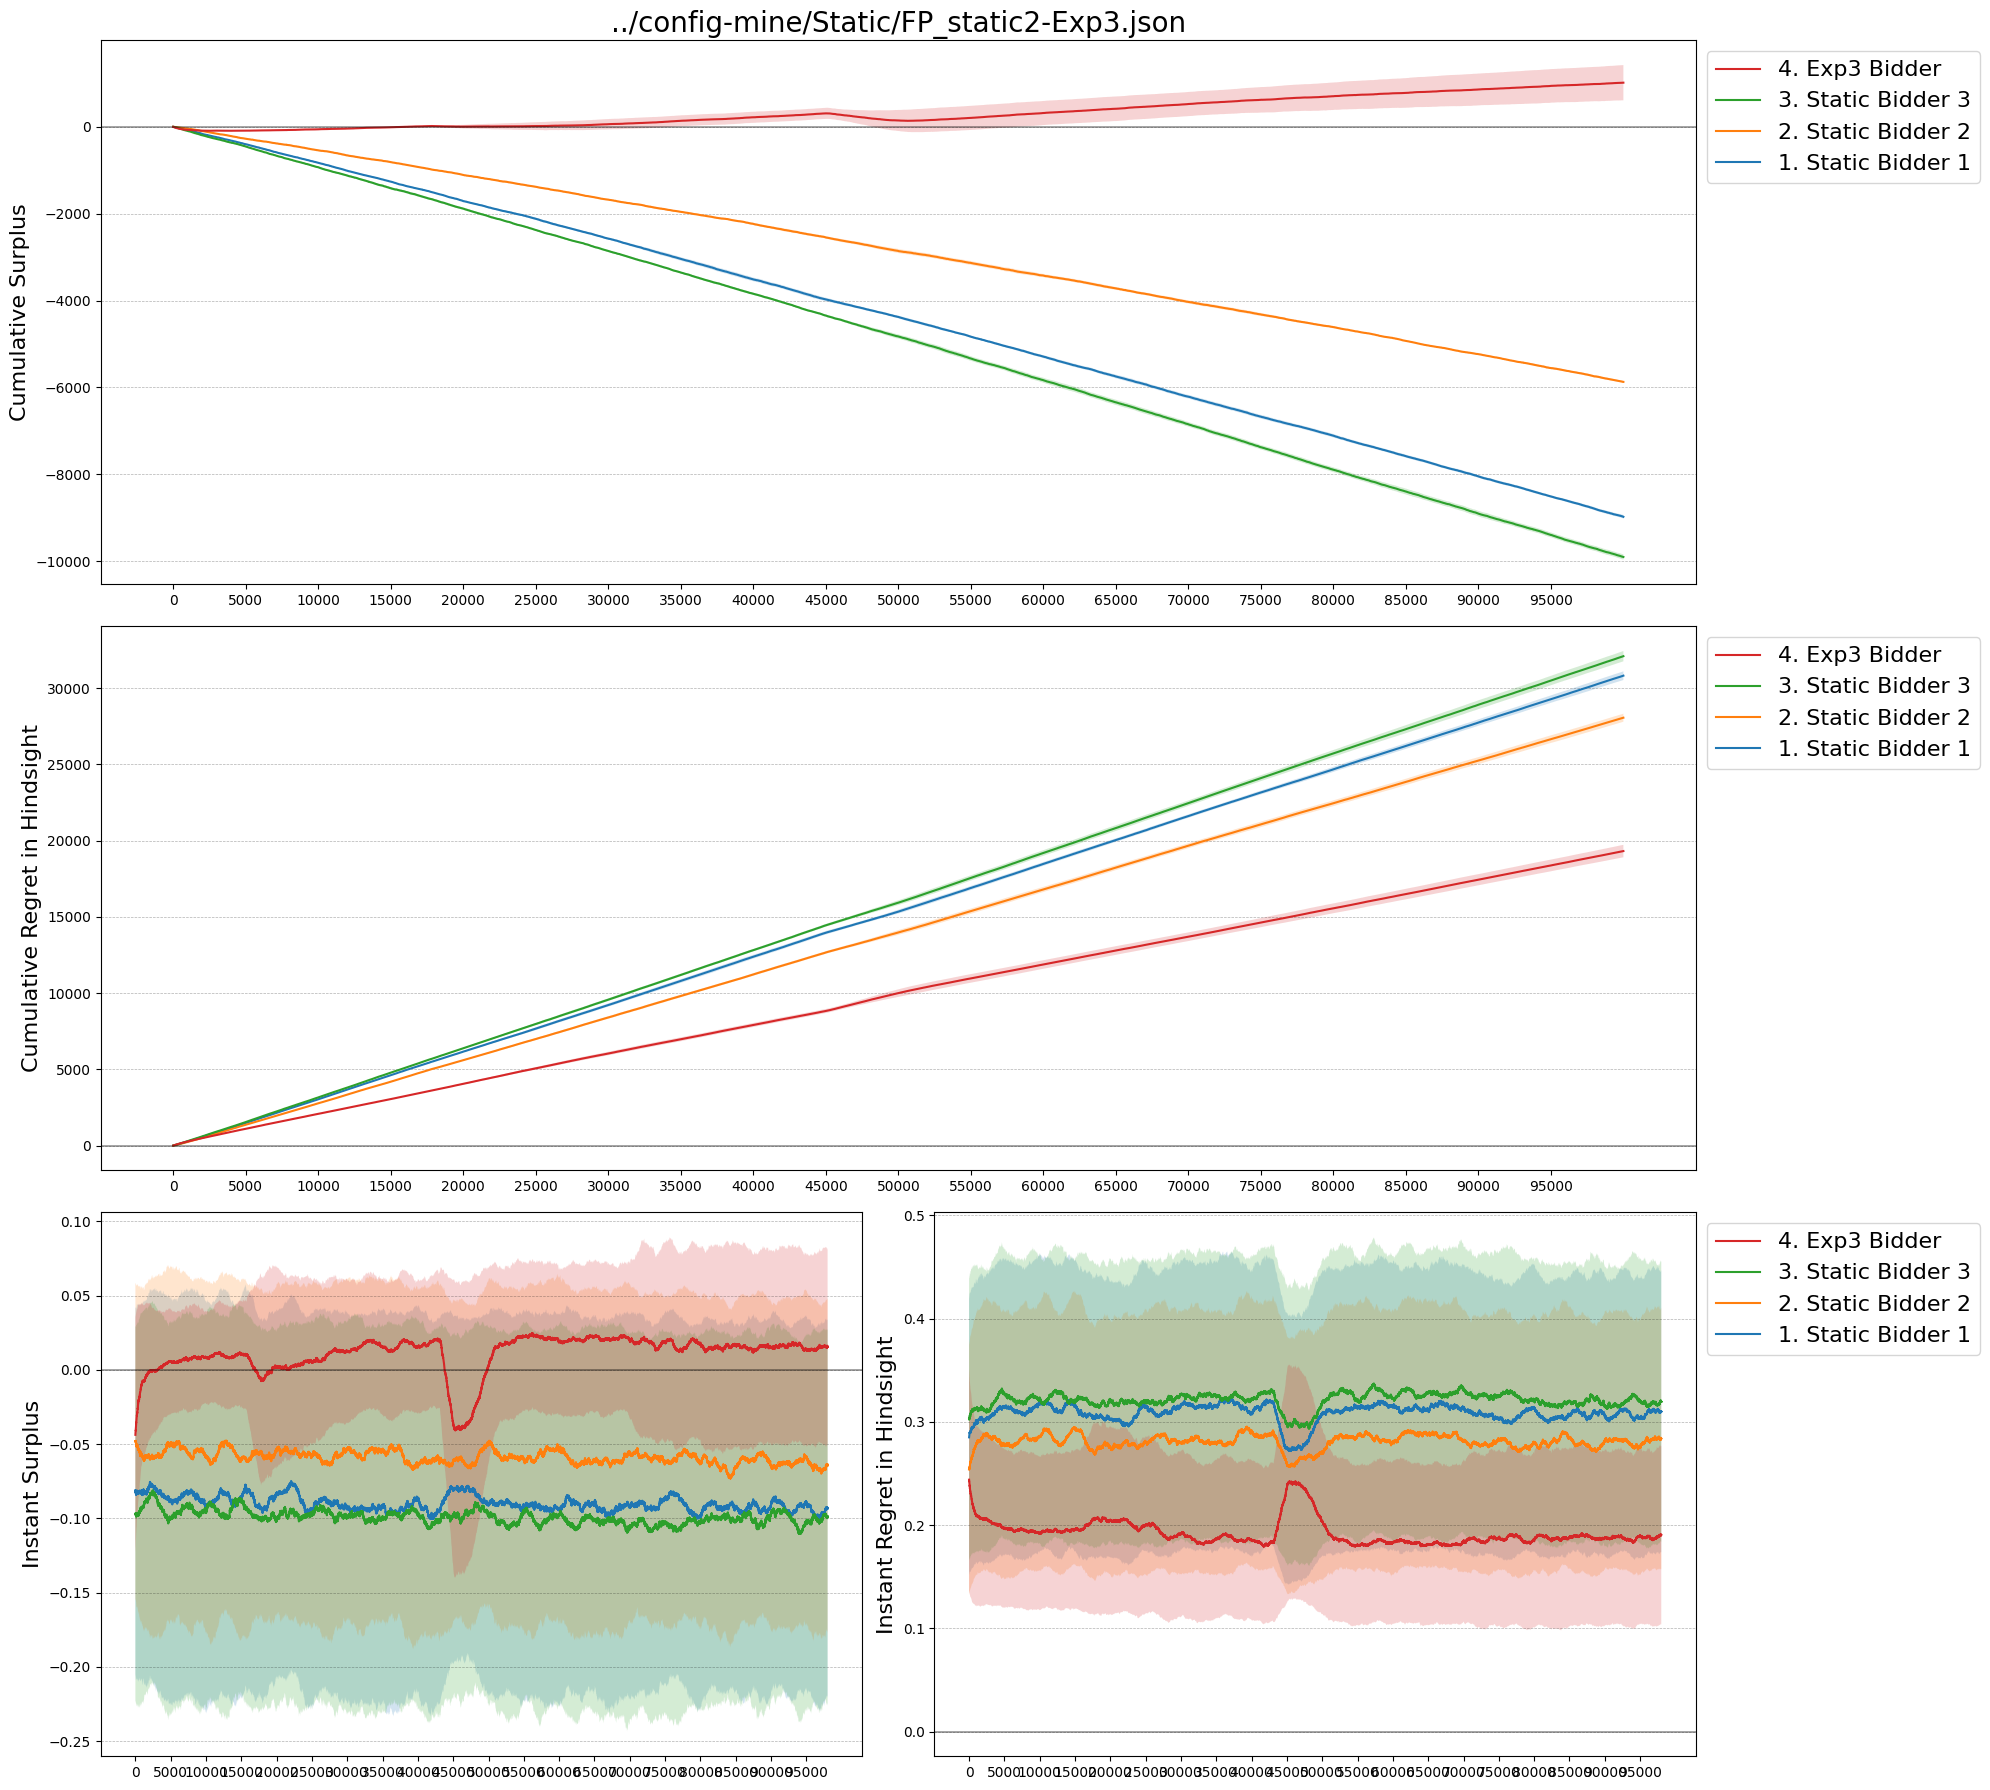

In [ ]:
%matplotlib inline

show_graph(runs_results)

['4. Exp3 Bidder']
(1, 5, 100000)


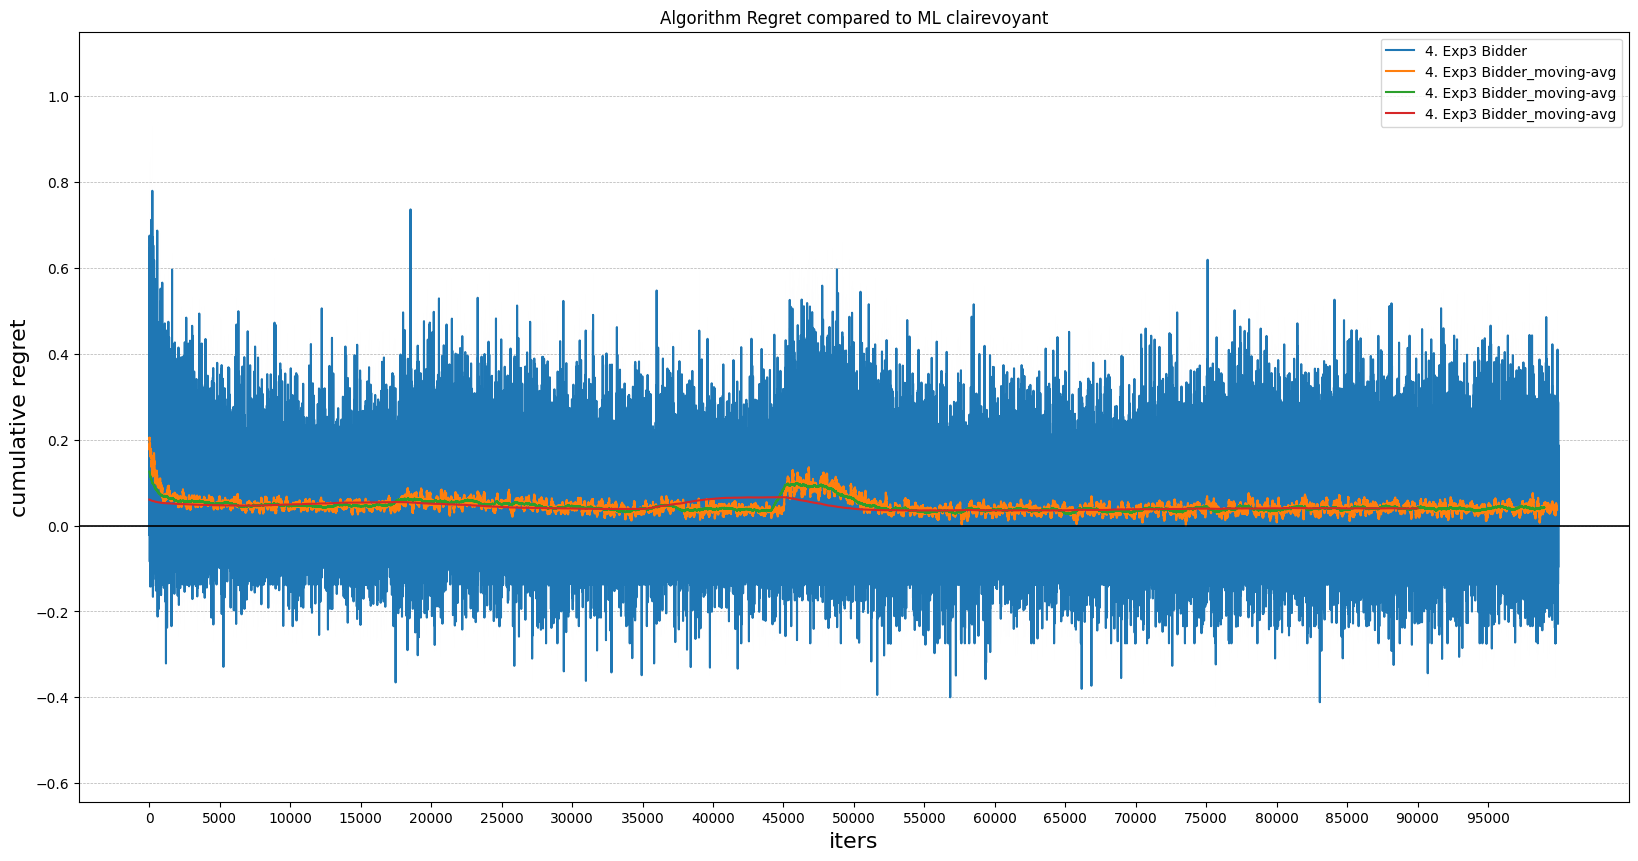

In [ ]:
%matplotlib inline

import re
rule = re.compile(r'static', re.IGNORECASE)
my_agents_names_no_static = [a for a in my_agents_names if not rule.search(a)]
print(my_agents_names_no_static)

fig, ax = plt.subplots(1,1, sharey='row', figsize=(20,10))

ax.set_title("Algorithm Regret compared to ML clairevoyant")

clairevoyant_regret = np.array([r[idx_cv_regret] for r in runs_results]).transpose(1,0,2)
print(clairevoyant_regret.shape)
data_amt = clairevoyant_regret.shape[2]
construct_graph(clairevoyant_regret, ax, 'iters', 'cumulative regret', 
                x_width=num_iter*config['rounds_per_iter'], names=my_agents_names_no_static, 
                insert_labels=False, fontsize=fontsize, moving_average=1)
construct_graph(clairevoyant_regret, ax, 'iters', 'cumulative regret', 
                x_width=num_iter*config['rounds_per_iter'], names=[n+'_moving-avg'for n in my_agents_names_no_static], 
                insert_labels=False, fontsize=fontsize, moving_average=data_amt//1000)
construct_graph(clairevoyant_regret, ax, 'iters', 'cumulative regret', 
                x_width=num_iter*config['rounds_per_iter'], names=[n+'_moving-avg'for n in my_agents_names_no_static], 
                insert_labels=False, fontsize=fontsize, moving_average=data_amt//100)
construct_graph(clairevoyant_regret, ax, 'iters', 'cumulative regret', 
                x_width=num_iter*config['rounds_per_iter'], names=[n+'_moving-avg'for n in my_agents_names_no_static], 
                insert_labels=False, fontsize=fontsize, moving_average=data_amt//10)

plt.legend()
plt.show()

In [ ]:
# %matplotlib qt

# show_graph(runs_results)

#### Run no. 7 was bad, removed to see how much it counted

In [ ]:
r = runs_results.copy()
r = np.array(r)
r = np.delete(r, 7, axis=0)
show_graph(r)

C:\Users\bona1\AppData\Local\Temp\ipykernel_21640\209663487.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  r = np.array(r)


IndexError: index 7 is out of bounds for axis 0 with size 5

In [ ]:
c = clairevoyant_regret.copy()
print(c.shape)
c = np.delete(c, 7, axis=1)
print(c.shape)

(1, 10, 10000)
(1, 9, 10000)


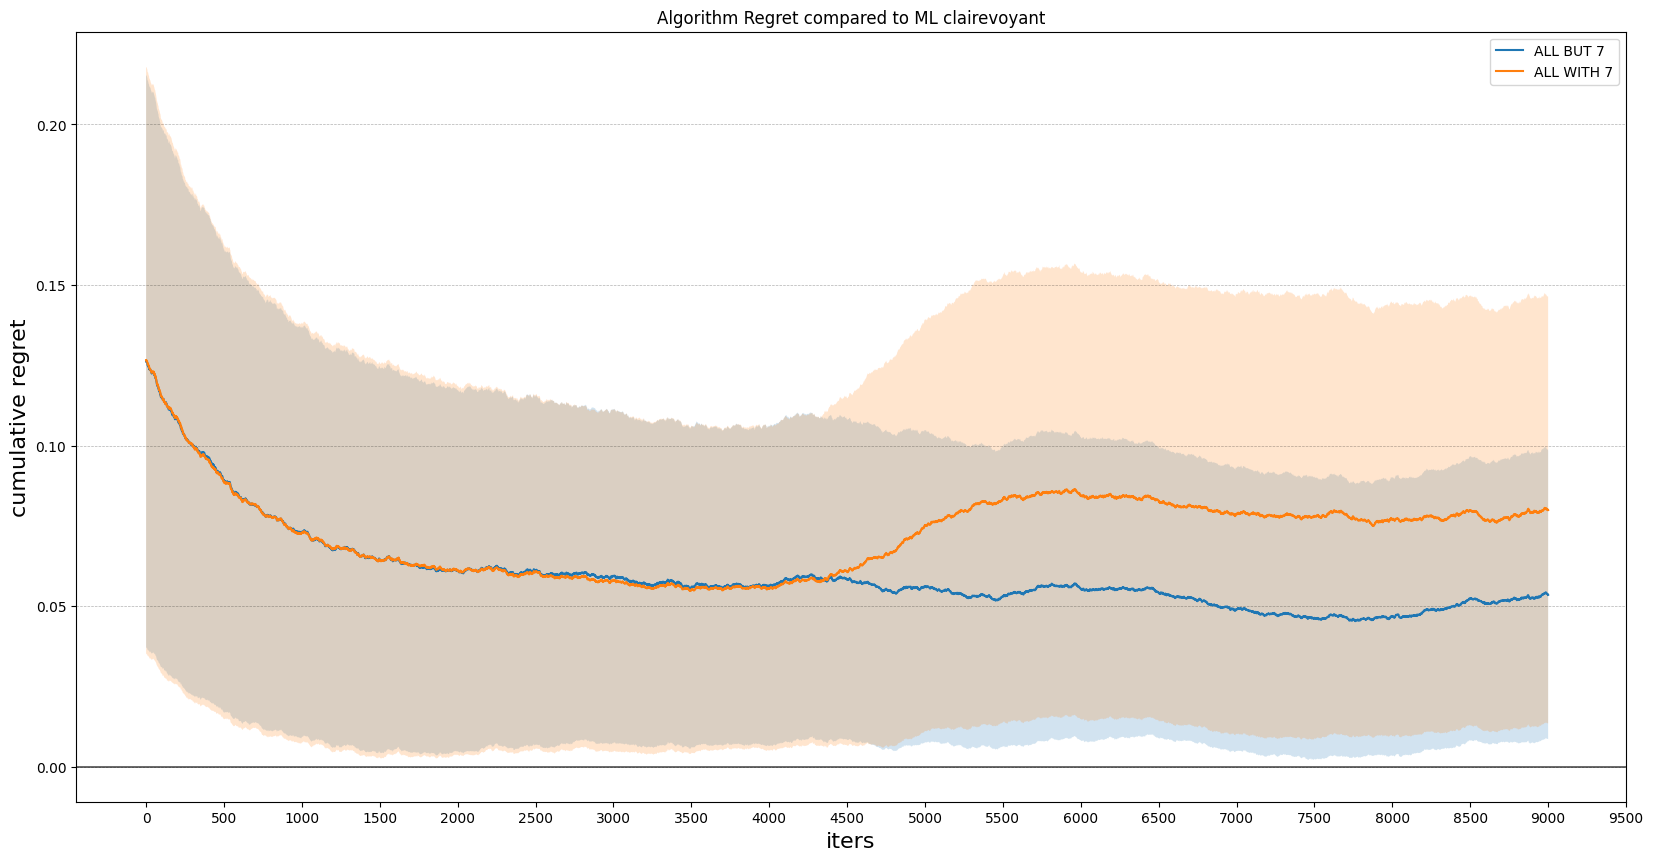

In [ ]:
### LA RUN NUMERO 7 É FOTTUTISSIMA

fig, ax = plt.subplots(1,1, sharey='row', figsize=(20,10))

ax.set_title("Algorithm Regret compared to ML clairevoyant")

data_amt = clairevoyant_regret.shape[2]
construct_graph(c, ax, 'iters', 'cumulative regret', 
                x_width=num_iter*config['rounds_per_iter'], names=['ALL BUT 7'], 
                insert_labels=False, fontsize=fontsize, moving_average=1000)
construct_graph(clairevoyant_regret, ax, 'iters', 'cumulative regret', 
                x_width=num_iter*config['rounds_per_iter'], names=["ALL WITH 7"], 
                insert_labels=False, fontsize=fontsize, moving_average=1000)

plt.legend()
plt.show()